## *Required Libraries*

In [86]:
import numpy as np
import pandas as pd
import requests
import os
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## *Loading the dataset using Tiingo API*

In [61]:
# Set your Tiingo API key
os.environ['TIINGO_API_KEY'] = '64f3e5fce53c85958846e25e4c4d10202b11d78a'

def get_tiingo_data(ticker, start_date, end_date):
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f"Token {os.getenv('TIINGO_API_KEY')}"
    }
    
    url = f"https://api.tiingo.com/tiingo/daily/{ticker}/prices"
    params = {
        'startDate': start_date,
        'endDate': end_date,
    }
    
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        data = response.json()
        data = pd.DataFrame(data)
        data['date'] = pd.to_datetime(data['date'])
        data.set_index('date', inplace=True)
        return data
    else:
        print(f"Error: {response.status_code}")
        return None

# Usage
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2024-01-01'

data = get_tiingo_data(ticker, start_date, end_date)

In [62]:
data.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,300.35,300.60,295.19,296.24,33911864,72.961236,73.021966,71.707765,71.962832,135647456,0.0,1.0
2020-01-03 00:00:00+00:00,297.43,300.58,296.50,297.15,36633878,72.251907,73.017108,72.025991,72.183890,146535512,0.0,1.0
2020-01-06 00:00:00+00:00,299.80,299.96,292.75,293.79,29644644,72.827630,72.866497,71.115039,71.367676,118578576,0.0,1.0
2020-01-07 00:00:00+00:00,298.39,300.90,297.48,299.84,27877655,72.485111,73.094842,72.264053,72.837346,111510620,0.0,1.0
2020-01-08 00:00:00+00:00,303.19,304.44,297.16,297.16,33090946,73.651131,73.954782,72.186319,72.186319,132363784,0.0,1.0


In [63]:
data=data.reset_index()

In [64]:
data.head()

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2020-01-02 00:00:00+00:00,300.35,300.60,295.19,296.24,33911864,72.961236,73.021966,71.707765,71.962832,135647456,0.0,1.0
1,2020-01-03 00:00:00+00:00,297.43,300.58,296.50,297.15,36633878,72.251907,73.017108,72.025991,72.183890,146535512,0.0,1.0
2,2020-01-06 00:00:00+00:00,299.80,299.96,292.75,293.79,29644644,72.827630,72.866497,71.115039,71.367676,118578576,0.0,1.0
3,2020-01-07 00:00:00+00:00,298.39,300.90,297.48,299.84,27877655,72.485111,73.094842,72.264053,72.837346,111510620,0.0,1.0
4,2020-01-08 00:00:00+00:00,303.19,304.44,297.16,297.16,33090946,73.651131,73.954782,72.186319,72.186319,132363784,0.0,1.0


In [65]:
data1=data['close']
data1.shape

(1006,)

## *Visualizing Stock Trends*

In [66]:

# Create the figure
fig = go.Figure()

# Add the line plot
fig.add_trace(go.Scatter(x=data1.index, y=data1.values, mode='lines', name='Stock Price'))

# Update the layout
fig.update_layout(
    title='Stock Trend',
    xaxis_title='Date',
    yaxis_title='Price',
    width=700,
    height=500
)

# Show the plot
fig.show()

## *Scaling Data using MinMaxScaler*

In [67]:
scaler=MinMaxScaler(feature_range=(0,1))
data1=scaler.fit_transform(np.array(data1).reshape(-1,1))

In [68]:
data1.shape

(1006, 1)

In [69]:
data1

array([[0.48468378],
       [0.47737007],
       [0.4833062 ],
       ...,
       [0.21618034],
       [0.21725736],
       [0.21462743]])

## *Splitting the Data*

In [70]:
# In TimeSeries data, every next value is always dependent on previous value

training_size=int(len(data1)*0.7) # 70% data for training and remaining for testing

train_data,test_data=data1[0:training_size,:1], data1[training_size:len(data1):,:1]

In [71]:
print(len(train_data))
print(len(test_data))

704
302


In [72]:
train_data.shape

(704, 1)

## *Converting an array of values into Dataset Matrix* 

In [73]:
def create_dataset(dataset, time_steps):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_steps, 0])

    return np.array(dataX), np.array(dataY)

In [74]:
time_steps=100
x_train,y_train=create_dataset(train_data,time_steps)
x_test,y_test=create_dataset(test_data,time_steps)

In [75]:
print(x_train.shape)
print(x_train)

(603, 100)
[[0.48468378 0.47737007 0.4833062  ... 0.52601127 0.53112085 0.52571071]
 [0.47737007 0.4833062  0.47977458 ... 0.53112085 0.52571071 0.52916719]
 [0.4833062  0.47977458 0.49179712 ... 0.52571071 0.52916719 0.52951785]
 ...
 [0.07641828 0.07701941 0.09084534 ... 0.08328115 0.0841077  0.08050094]
 [0.07701941 0.09084534 0.08395742 ... 0.0841077  0.08050094 0.07889793]
 [0.09084534 0.08395742 0.08435817 ... 0.08050094 0.07889793 0.09054477]]


In [76]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

## *Model Building*

In [77]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

*Model Compilation*

In [78]:
model.compile('adam', loss='mean_squared_error')

In [79]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
10/10 [==============================] - 6s 233ms/step - loss: 0.0289 - val_loss: 0.0012
Epoch 2/100
10/10 [==============================] - 1s 142ms/step - loss: 0.0177 - val_loss: 2.5410e-04
Epoch 3/100
10/10 [==============================] - 1s 133ms/step - loss: 0.0114 - val_loss: 0.0011
Epoch 4/100
10/10 [==============================] - 1s 125ms/step - loss: 0.0119 - val_loss: 1.8890e-04
Epoch 5/100
10/10 [==============================] - 1s 145ms/step - loss: 0.0097 - val_loss: 3.7459e-04
Epoch 6/100
10/10 [==============================] - 1s 119ms/step - loss: 0.0085 - val_loss: 5.2994e-04
Epoch 7/100
10/10 [==============================] - 1s 146ms/step - loss: 0.0078 - val_loss: 1.6789e-04
Epoch 8/100
10/10 [==============================] - 2s 164ms/step - loss: 0.0069 - val_loss: 1.8480e-04
Epoch 9/100
10/10 [==============================] - 2s 190ms/step - loss: 0.0064 - val_loss: 1.8600e-04
Epoch 10/100
10/10 [==============================] - 2s 165ms/

In [81]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

7/7 [==============================] - 0s 26ms/step


In [82]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [83]:
math.sqrt(mean_squared_error(y_train,train_predict))

188.10614617256732

In [84]:
math.sqrt(mean_squared_error(y_test,test_predict))

179.25578628863948

## *Plotting*

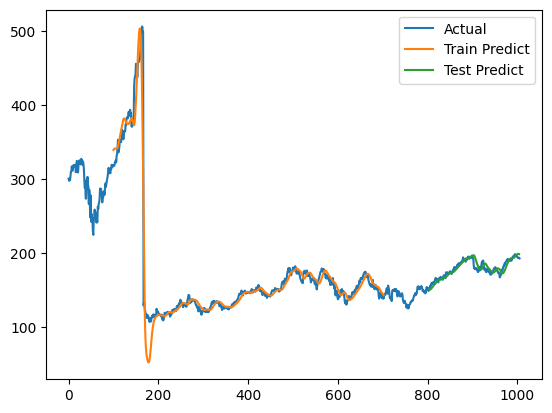

In [88]:
look_back = 100

# Initialize arrays with NaNs for plotting predictions
trainPredictPlot = np.full_like(data1, np.nan)
testPredictPlot = np.full_like(data1, np.nan)

# Populate the train prediction plot array
trainPredictPlot[look_back:look_back + len(train_predict)] = train_predict

# Populate the test prediction plot array
start_idx = len(train_predict) + look_back * 2 + 1
end_idx = len(data1) - 1
testPredictPlot[start_idx:end_idx] = test_predict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(data1), label='Actual')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.legend()
plt.show()


In [89]:
len(test_data)

302

In [93]:
x_input=test_data[202:].reshape(1,-1)
x_input.shape

(1, 100)

In [96]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [97]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} days input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input=x_input.reshape((1,n_steps,1))
        yhat=model.predict(x_input, verbose=0)
        print("{} days input {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input=x_input.reshape((1,n_steps,1))
        yhat=model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input)) 
        lst_output.extend(yhat.tolist())
        i=i+1

print(lst_output)

[0.22749633]
101
1 days input [0.17815905 0.1777082  0.18189105 0.17685661 0.17465247 0.1682154
 0.16944271 0.17282405 0.17630557 0.18604884 0.17417658 0.17976205
 0.18371947 0.19356293 0.20240451 0.20295554 0.20693801 0.20753914
 0.19053225 0.17713212 0.17868503 0.18164058 0.17397621 0.16874139
 0.17257358 0.17074515 0.17815905 0.18091421 0.1719474  0.16804008
 0.17019411 0.17342517 0.16310582 0.15927364 0.15992486 0.1612273
 0.16758923 0.16420789 0.16736381 0.17049468 0.17695679 0.18071384
 0.17921102 0.18274264 0.18502192 0.18036318 0.18003757 0.1761052
 0.17282405 0.17187226 0.16541014 0.16571071 0.16681277 0.16095178
 0.15040701 0.15373826 0.15892298 0.16012523 0.16814026 0.17715717
 0.17485285 0.18131497 0.18780213 0.19048215 0.1892799  0.19927364
 0.19526612 0.20187852 0.2033062  0.20756418 0.20751409 0.21192235
 0.20989355 0.2115717  0.2082154  0.20776456 0.20929242 0.20671259
 0.20816531 0.21139637 0.20686287 0.21685661 0.21410144 0.2189856
 0.22259236 0.21625548 0.22008766 0.

In [98]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)


In [99]:
data2=data1.tolist()
data2.extend(lst_output)

In [100]:
len(data1)

1006

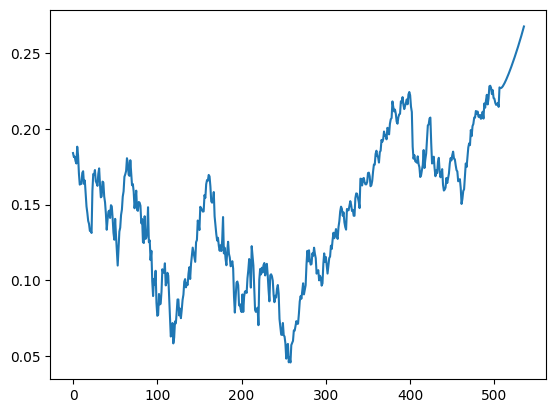

In [108]:
plt.plot(data2[500:])

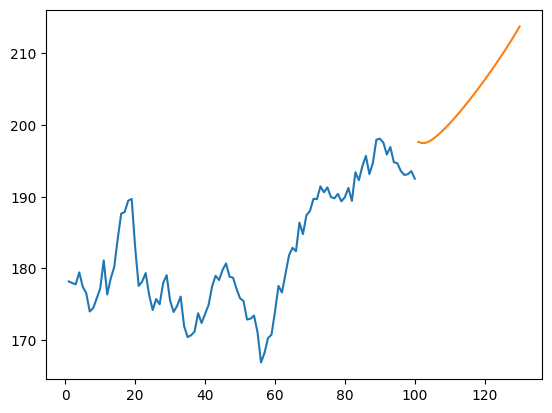

In [104]:
plt.plot(day_new,scaler.inverse_transform(data1[906:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.show()